# CS221 - Project

* Build Model
* Download Colorectal histography data
* Compile Model
* Setup Tensorboard callback
* Setup Checkpoints callback
* Train the model
* Evaluate accuracy
* Inference
* View weights and bias

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import random
import pathlib
SEED = 1965284
random.seed(SEED)
np.random.seed(SEED)
print(tf.__version__)

2.4.1


In [2]:
#tfds.list_builders()
#dset = tfds.load('colorectal_histology_large', split='train[:80%]', shuffle_files=True, \
#                 as_supervised=True, data_dir="/mnt/d/projct/data/")


In [6]:
def load_dataset(dataset_directory_path):
    classes = os.listdir(dataset_directory_path)
    examples = []
    X, Y = [], []
    for label in classes:
        num_samples = len(os.listdir(os.path.join(dataset_directory_path,label)))
        print(label + '\t' + str(num_samples))
        random_image_index = random.choice(np.arange(num_samples)) 
        random_image_filename = os.listdir(os.path.join(dataset_directory_path,label))[random_image_index] 
        with Image.open(os.path.join(dataset_directory_path,label, random_image_filename)) as img:
            examples.append( np.array(img))

        y_label = int(label[:2])
        print("label, y_label : ", label, y_label)

        file_names = os.listdir(os.path.join(dataset_directory_path,label))
        for file_name in file_names:
            with Image.open(os.path.join(dataset_directory_path,label, random_image_filename)) as img:
                X.append( np.array(img)/255.0 )
                Y.append(y_label)
        print("len(X), len(Y) : ", len(X), len(Y))
    
    print(Y[:10])
    temp = list(zip(X,Y))
    random.shuffle(temp)
    X,Y = zip(*temp)
    print(Y[:10])
    X = np.array(X)
    Y = np.array(Y)
    return(X, Y, examples, classes)


DATASET_DIR = "./data/colorectal_histology/Kather_texture_2016_image_tiles_5000/"
X,Y,examples,classes = load_dataset(DATASET_DIR)

01_TUMOR	625
label, y_label :  01_TUMOR 1
len(X), len(Y) :  625 625
02_STROMA	625
label, y_label :  02_STROMA 2
len(X), len(Y) :  1250 1250
03_COMPLEX	625
label, y_label :  03_COMPLEX 3
len(X), len(Y) :  1875 1875
04_LYMPHO	625
label, y_label :  04_LYMPHO 4
len(X), len(Y) :  2500 2500
05_DEBRIS	625
label, y_label :  05_DEBRIS 5
len(X), len(Y) :  3125 3125
06_MUCOSA	625
label, y_label :  06_MUCOSA 6
len(X), len(Y) :  3750 3750
07_ADIPOSE	625
label, y_label :  07_ADIPOSE 7
len(X), len(Y) :  4375 4375
08_EMPTY	625
label, y_label :  08_EMPTY 8
len(X), len(Y) :  5000 5000
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
(6, 2, 1, 7, 3, 3, 7, 3, 4, 5)


0.043137254901960784 1.0 [0.43921569 0.22745098 0.41568627]
[6 2 1 7 3 3 7 3 4 5]


<ipython-input-7-c2dfd1a95fb2>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


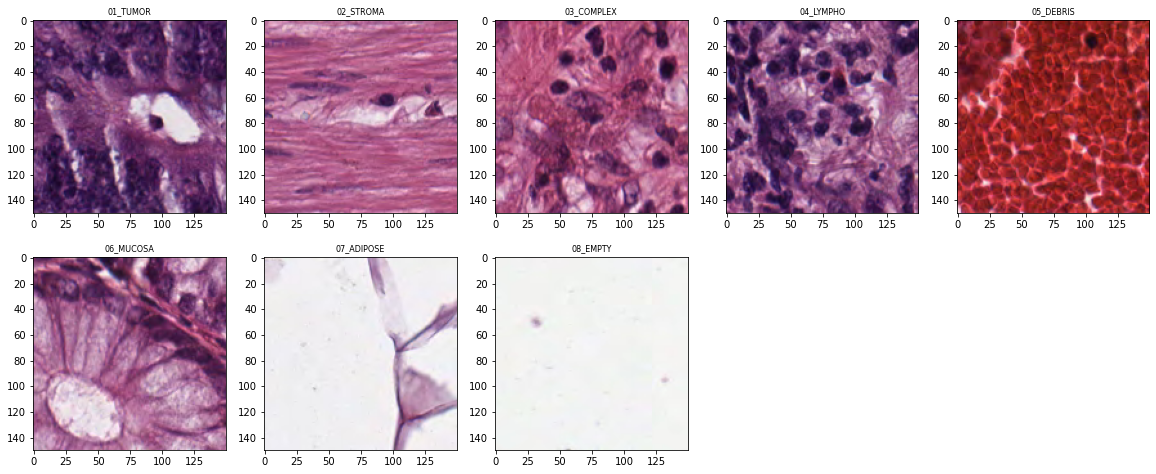

In [7]:
def show_examples(images, labels,
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
        
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.title(labels[i], fontsize=label_font_size); 
        
print(np.amin(X[0]), np.amax(X[0]), X[0][0,0,:10])
print(Y[:10])

show_examples(examples, classes)

# Discriminator

* Create discriminator model
* Create fake dataset
* Mix fake and real dataset and train descriminator

In [8]:
def discriminator(dim=150, learningRate=0.002):
    model = tf.keras.Sequential()
    
    model.add( tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', input_shape=(dim,dim,3)) ) 
    model.add( tf.keras.layers.LeakyReLU(alpha=0.2) )
    # input  shape: 150, 150, 3
    # output shape: 150, 150, 64
    # parameters: weights=(3*3*3)*64 , biases=64

    model.add( tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same') )
    model.add( tf.keras.layers.LeakyReLU(alpha=0.2) )
    # input  shape: 150, 150, 64
    # output shape: 150, 150, 128
    # parameters: weights=(3*3*64)*128 , biases=128

    model.add( tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same') )
    model.add( tf.keras.layers.LeakyReLU(alpha=0.2) )
    # input  shape: 150, 150, 128
    # output shape: 150, 150, 128
    # parameters: weights=(3*3*128)*128 , biases=128
    
    model.add( tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same') )
    model.add( tf.keras.layers.LeakyReLU(alpha=0.2) )
    # input  shape: 150, 150, 128
    # output shape: 150, 150, 256
    # parameters: weights=(3*3*128)*256 , biases=256

    model.add( tf.keras.layers.Flatten()) 
    model.add( tf.keras.layers.Dropout(0.4) ) 
    model.add( tf.keras.layers.Dense(1, activation="sigmoid") ) 
    
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=learningRate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

In [9]:
model_d = discriminator()
model_d.summary()
tf.keras.utils.plot_model(model_d, "model_discriminator.png", show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 256)       2

In [19]:
def generate_fake_samples(dim, n_samples):
    X = np.random.rand(dim * dim * 3 * n_samples)
    X = X.reshape((n_samples, dim, dim, 3))
    Y = np.zeros(n_samples, dtype=int)
    return X, Y

In [24]:
X_fake, Y_fake = generate_fake_samples(dim=150, n_samples=5000)
Y_real = np.ones(5000, dtype=int)
print(X.shape)
print(Y.shape)
print(X_fake.shape)
print(Y_fake.shape)
print(Y[0],Y_fake[0], Y_real[0])
X_d = np.concatenate((X, X_fake))
Y_d = np.concatenate((Y_real, Y_fake))
print(X_d.shape)
print(Y_d.shape)

temp = list(zip(X_d,Y_d))
random.shuffle(temp)
X_d,Y_d = zip(*temp)
X_d = np.array(X_d)
Y_d = np.array(Y_d)
print(X_d.shape)
print(Y_d.shape)

(5000, 150, 150, 3)
(5000,)
(5000, 150, 150, 3)
(5000,)
6 0 1
(10000, 150, 150, 3)
(10000,)
(10000, 150, 150, 3)
(10000,)


In [ ]:
model_d.fit(X_d, Y_d, epochs=20, batch_size=64, 
          shuffle=True, validation_split=0.1, verbose=1
         )

Epoch 1/20
 73/141 [==============>...............] - ETA: 1:27 - loss: 1.3585 - accuracy: 0.8169